In [1]:
import torch
import torch.nn as nn
import scipy.ndimage as ndi
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
import os
import nibabel as nib
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import closing, remove_small_objects, disk, ball
from scipy.ndimage import binary_fill_holes, label
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from torch.cuda.amp import GradScaler, autocast

In [2]:
#Generate a 3D binary mask using Otsu thresholding and morphological operations.
def create_foreground_mask(volume):
    mask = np.zeros_like(volume, dtype=np.uint8)

    for i in range(volume.shape[0]):  # iterate over axial slices
        slice_img = volume[i, :, :]

        # Normalize to [0, 1] for consistent thresholding
        slice_norm = (slice_img - slice_img.min()) / (slice_img.ptp() + 1e-5)

        # Otsu thresholding
        thresh = threshold_otsu(slice_norm)
        binary = slice_norm > thresh

        # Morphological cleanup
        binary = closing(binary, disk(3))
        binary = binary_fill_holes(binary)
        binary = remove_small_objects(binary, min_size=100)

        mask[i, :, :] = binary.astype(np.uint8)

    return mask

#Save the mask as a .nii.gz file with the same affine and header as the input image.
def save_mask(mask, reference_nii, output_path):
    mask_nifti = nib.Nifti1Image(mask.astype(np.uint8), affine=reference_nii.affine, header=reference_nii.header)
    nib.save(mask_nifti, output_path)

def create_mask(img_data):
    # 1) Threshold to remove air/background
    mask0 = img_data > (0.05 * img_data.max())

    mask1 = closing(mask0, ball(radius=3))

    # 2) Keep only the largest connected component (the head)
    labels, n = ndi.label(mask1)
    sizes = ndi.sum(mask1, labels, range(1, n+1))
    largest = np.argmax(sizes) + 1
    whole_head_mask = (labels == largest).astype(np.uint8)
    return whole_head_mask



In [3]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/folder_name/your_file.csv'


Mounted at /content/drive


In [ ]:
#generate masks for every inv2 volume
def process_all_nii(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    nii_files = [f for f in os.listdir(input_folder) if f.endswith(".nii.gz")]

    for f in tqdm(nii_files, desc="Processing subjects"):
        input_path = os.path.join(input_folder, f)
        output_path = os.path.join(output_folder, f.replace(".nii.gz", "_mask.nii.gz"))

        nii = nib.load(input_path)
        vol = nii.get_fdata()

        mask = create_mask(vol)
        save_mask(mask, nii, output_path)

    print(f"\nDone! {len(nii_files)} mask(s) saved to: {output_folder}")

input_folder = "/content/drive/My Drive/lemon_data/inv2_volumes"
output_folder = "/content/drive/My Drive/lemon_data/inv2_masks"

process_all_nii(input_folder, output_folder)

In [5]:
#dataset of nii.gz files
class NiftiDataset3D(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
        self.transform = transform   #none for now

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        img = np.expand_dims(img, axis=0)  # [1, D, H, W]
        mask = np.expand_dims(mask, axis=0)  # [1, D, H, W]

        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask
#image and mask
image_dir = '/content/drive/My Drive/lemon_data/inv2_volumes'  # Folder of .nii.gz volumes
mask_dir = '/content/drive/My Drive/lemon_data/inv2_masks'    # Corresponding masks

dataset = NiftiDataset3D(image_dir, mask_dir)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
#convolution block for a u-net
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

#3D U-net class
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.enc1 = ConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock3D(64, 128)

        self.upconv2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock3D(128, 64)

        self.upconv1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock3D(64, 32)

        self.final = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))

        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

In [7]:
#loss function: dice loss
def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)  # if using raw logits
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return 1 - (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

In [8]:
#use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#3d U-net
model = UNet3D().to(device)
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
#training loop
def train(epochs, accumulate_grad_batches=4):
    model.train()
    scaler = GradScaler()  # Initialize GradScaler for mixed precision
    for epoch in range(epochs):
        total_loss = 0
        optimizer.zero_grad()
        for i, (imgs, masks) in enumerate(loader):
            imgs, masks = imgs.to(device), masks.to(device)

            with autocast():  # Autocast for mixed precision
                outputs = model(imgs)
                loss = dice_loss(outputs, masks)
                loss = loss / accumulate_grad_batches

            scaler.scale(loss).backward()  # Scale the loss and call backward()

            if (i + 1) % accumulate_grad_batches == 0:
                scaler.step(optimizer)  # Optimizer step with scaler
                scaler.update()  # Update the scaler
                optimizer.zero_grad()

            total_loss += loss.item() * accumulate_grad_batches

        if (i + 1) % accumulate_grad_batches != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}: Loss = {total_loss/len(loader):.4f}")

In [23]:
#train and save parameters
train(5)
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/3d_segmentation.pth')

/tmp/ipython-input-21-4199689982.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed precision
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

Epoch 1: Loss = 0.4591


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 2: Loss = 0.3857


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 3: Loss = 0.3440


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 4: Loss = 0.3208


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Autocast for mixed precision
/tmp/ipython-input-21-4199689982.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 5: Loss = 0.3084


In [10]:
#load parameters
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/3d_segmentation.pth'))

<All keys matched successfully>

In [11]:
#function to predict mask using data
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device).unsqueeze(0)  # Add batch dimension
        output = model(image_tensor)
        return output.cpu()

#edit an image based on mask
def maskEditing(image, mask, threshold=-0.5):
    new_img = torch.tensor(image.copy())  # Create a new tensor from a NumPy copy
    if not torch.is_tensor(mask):
        mask = torch.tensor(mask)

    for l in range(mask.size(2)):
        for w in range(mask.size(1)):
            if mask[0, w, l] < threshold:
                new_img[:, w, l] = -1  #set background voxels to -1

    return new_img  # return as numpy array to keep format consistent

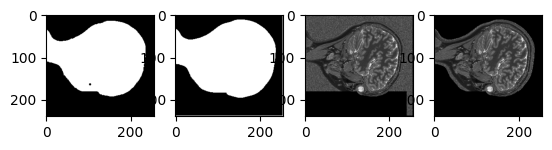

In [12]:
slice_idx = 125  #index of one layer of head

# Load the full 3D volume and mask
full_inv2_volume = dataset[12][0]  # Shape: [1, D, H, W]
full_mask_volume = dataset[12][1]  # Shape: [1, D, H, W]

inv2mask_full = predict(model, full_inv2_volume) #Generate mask based on inv2 image

# Select the desired slice from the original volume and the predicted mask
inv2_slice = full_inv2_volume[:, slice_idx, :, :].numpy() # Shape: [1, H, W], slice of inv2 image
mask_slice = full_mask_volume[:, slice_idx, :, :] # Shape: [1, H, W], slice of ground truth mask
inv2mask_slice = inv2mask_full.squeeze(0)[:, slice_idx, :, :] # Shape: [1, H, W], slice of

#load corresponding t1map image
t1map = nib.load("/content/drive/My Drive/lemon_data/t1map_volumes/sub-032394_ses-01_acq-mp2rage_T1map.nii.gz")
t1mapdata = t1map.get_fdata()
t1map_slice = t1mapdata[slice_idx, :, :] #get slice of t1map image

binaryMask = (inv2mask_slice > -0.95).float() #create binary mask

#edit t1map image based on mask
edited_t1map = maskEditing(t1mapdata, binaryMask, threshold=0.05)
edited_t1map_slice = edited_t1map[slice_idx, :, :]

plt.subplot(1, 4, 1)
plt.imshow(mask_slice.squeeze(0), cmap="gray") #display ground truth mask
plt.subplot(1, 4, 2)
plt.imshow(binaryMask.squeeze(1).squeeze(0).squeeze(0), cmap="gray") #display generated mask
plt.subplot(1, 4, 3)
plt.imshow(t1map_slice, cmap="gray") #display original t1map image
plt.subplot(1, 4, 4)
plt.imshow(edited_t1map_slice, cmap="gray") #display edited t1map image